# Weather analysis with python
* It feels like this summer has been hot longer than usual: how to use
* Python itertools for finding the maximum consecutive occurrences (e.g. days above 90 degrees)
* Considered displaying the results with the alpha python shiny app - although that solution would likely change with beta

In [1]:
from itertools import groupby
import pandas as pd
import seaborn as sns
sns.set_theme(style='whitegrid')


# Exploratory Data Analysis and Data Wrangling

In [2]:
# Import the most historic data and conduct exploratory data analysis
df_1871 = pd.read_csv('./data/97214_portland_1871-11_1973-06_temp.csv')
df_1871.head()
df_1871.STATION.unique() # just 'USW00024274'
df_1871.NAME.unique() # just 'PORTLAND REGIONAL FORECAST OFFICE CITY, OR US'
df_1871.DATE.min() # '1871-11-19'
df_1871 = df_1871[df_1871['DATE']>'1871-12-31'] # to only have full-year data
df_1871.DATE.max() # '1973-06-30'
# I'm not checking for completeness, to ensure every date has data, at this time
# could sum to see if 365 or 366 days in each year, or could validate against calendar

df_1871.describe()

,PRCP,SNOW,TMAX,TMIN
count,37037.000000,32603.000000,36141.000000,36116.000000
mean,0.116940,0.028881,61.883014,45.949413
std,0.266723,0.348195,14.049329,9.402705
min,0.000000,0.000000,9.000000,-56.000000
25%,0.000000,0.000000,51.000000,39.000000
50%,0.000000,0.000000,61.000000,46.000000
75%,0.110000,0.000000,72.000000,53.000000
max,6.680000,15.500000,107.000000,77.000000


In [3]:
# Import data up to the current date and remove overlaps 
df_2022 = pd.read_csv('./data/97218_portland_1940_2022-11_temp_prec.csv')
df_2022.head()
df_2022.STATION.unique() # just 'USW00024229'
df_2022.NAME.unique() # just 'PORTLAND INTERNATIONAL AIRPORT, OR US'
df_2022.DATE.min() # '1940-10-14'
df_2022.DATE.max() # '2022-08-08'
df_2022 = df_2022[df_2022['DATE']>df_1871.DATE.max()] # no overlap
print(df_2022.DATE.min())

1973-07-01


In [4]:
# Combine the data frames (in this case the columns all match, so this is easy)
print(df_1871.shape)
print(df_2022.shape)
df = pd.concat([df_2022, df_1871])
print(df.shape)
df.head()

(37040, 7)
(18023, 7)
(55063, 7)


,STATION,NAME,DATE,PRCP,SNOW,TMAX,TMIN
11948,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",1973-07-01,0.0,0.0,75.0,53.0
11949,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",1973-07-02,0.0,0.0,82.0,53.0
11950,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",1973-07-03,0.0,0.0,85.0,54.0
11951,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",1973-07-04,0.0,0.0,81.0,59.0
11952,USW00024229,"PORTLAND INTERNATIONAL AIRPORT, OR US",1973-07-05,0.0,0.0,72.0,57.0


In [5]:
df = df.assign(DATE = pd.to_datetime(df['DATE']).dt.date)
df = df.assign(YEAR = pd.to_datetime(df['DATE']).dt.year)

# Analysis

## The number of days per year of at least X degree fahrenheit maximum temperature

In [6]:
# The number of days per year of at least a 100 degree fahrenheit maximum temperature
df_tmax = df.copy()[['DATE', 'YEAR', 'TMAX']]
df_tmax = df_tmax.assign(F100 = df_tmax['TMAX']>=100)
df_tmax = df_tmax.assign(F90 = df_tmax['TMAX']>=90)
df_tmax = df_tmax.assign(F80 = df_tmax['TMAX']>=80)
df_tmax.head()

# df_tmax = df_tmax.assign(F110 = df_tmax['TMAX']>=110)
# df_tmax[df_tmax['F110']==True] # Only once has this happened, for a two-day period

,DATE,YEAR,TMAX,F100,F90,F80
11948,1973-07-01,1973,75.0,False,False,False
11949,1973-07-02,1973,82.0,False,False,True
11950,1973-07-03,1973,85.0,False,False,True
11951,1973-07-04,1973,81.0,False,False,True
11952,1973-07-05,1973,72.0,False,False,False


In [7]:
df_tmax[df_tmax['YEAR']==1872] # NaN for TMAX
df_tmax = df_tmax.dropna()
df_tmax.YEAR.min() # 1874
df_tmax.describe()

,YEAR,TMAX
count,54163.000000,54163.000000
mean,1948.165907,62.372450
std,42.842356,14.249816
min,1874.000000,9.000000
25%,1911.000000,52.000000
50%,1948.000000,61.000000
75%,1985.000000,73.000000
max,2022.000000,116.000000


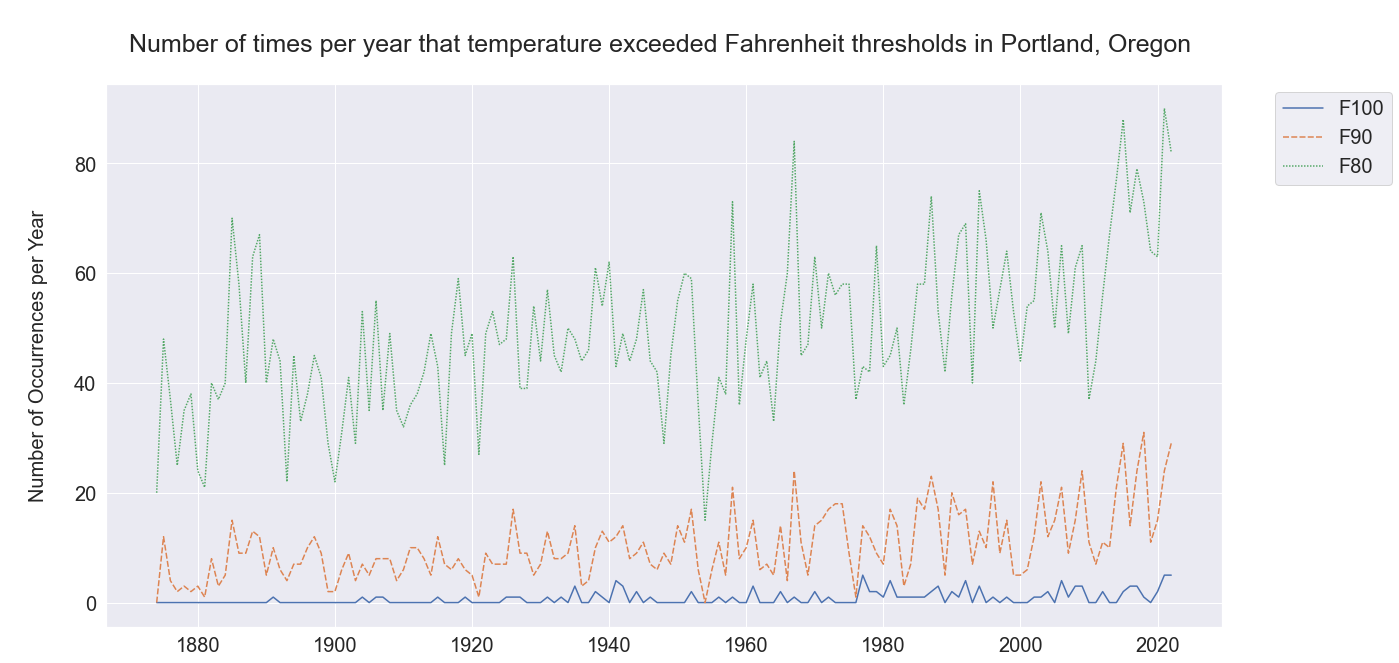

In [8]:
dfp = df_tmax[df_tmax['DATE']<pd.to_datetime('2023-01-01')] # to only have full-year data
# dfp = df_tmax
dfp = dfp.groupby(['YEAR']).sum().drop('TMAX', axis=1)

p = sns.set(rc={'figure.figsize':(20,10)})
p = sns.lineplot(data=dfp)

# title # 
p.set_title('\nNumber of times per year that temperature exceeded Fahrenheit thresholds \
in Portland, Oregon \n', fontsize=25)
p.set_xlabel("\n", fontsize=20)
p.set_ylabel("\nNumber of Occurrences per Year\n", fontsize=20)
p.tick_params(axis='x', labelsize=20)
p.tick_params(axis='y', labelsize=20)
p.legend(loc=10, prop={'size': 20})
legend = p.get_legend()
legend.set_bbox_to_anchor((1.1, .9))

## Longest streak of consecutive days above X degrees per year

In [9]:
dfl = df_tmax.copy()[['YEAR', 'F100', 'F90', 'F80']].sort_values('YEAR')

In [10]:
# longest consecutive trend
def groups(list):
    return [sum(g) for i, g in groupby(list) if i == 1]

In [11]:
# 80 degrees fahrenheit
def consecutive_F80():
    """
    F80: Maximum consecutive days where tmax was 80 degrees fahrenheit or higher
    """
    consecutive_days = []
    years = []
    for year in range(dfl['YEAR'].min(), dfl['YEAR'].max()+1):
        if sum(dfl[dfl['YEAR']==year]['F80'])==0:
            consecutive_days.append(0)
            years.append(year)
        else:
            consecutive_days.append(max(groups(dfl[dfl['YEAR']==year]['F80'])))
            years.append(year)
    return pd.DataFrame(list(zip(years, consecutive_days)), columns=['YEAR', 'F80'])
F80_df = consecutive_F80()

In [12]:
# 90 degrees fahrenheit
def consecutive_F90():
    """
    F90: Maximum consecutive days where tmax was 90 degrees fahrenheit or higher
    """
    consecutive_days = []
    years = []
    for year in range(dfl['YEAR'].min(), dfl['YEAR'].max()+1):
        if sum(dfl[dfl['YEAR']==year]['F90'])==0:
            consecutive_days.append(0)
            years.append(year)
        else:
            consecutive_days.append(max(groups(dfl[dfl['YEAR']==year]['F90'])))
            years.append(year)
    return pd.DataFrame(list(zip(years, consecutive_days)), columns=['YEAR', 'F90'])
F90_df = consecutive_F90()

In [13]:
# 100 degrees fahrenheit
def consecutive_F100():
    """
    F100: Maximum consecutive days where tmax was 100 degrees fahrenheit or higher
    """
    consecutive_days = []
    years = []
    for year in range(dfl['YEAR'].min(), dfl['YEAR'].max()+1):
        if sum(dfl[dfl['YEAR']==year]['F100'])==0:
            consecutive_days.append(0)
            years.append(year)
        else:
            consecutive_days.append(max(groups(dfl[dfl['YEAR']==year]['F100'])))
            years.append(year)
    return pd.DataFrame(list(zip(years, consecutive_days)), columns=['YEAR', 'F100'])

F100_df = consecutive_F100()

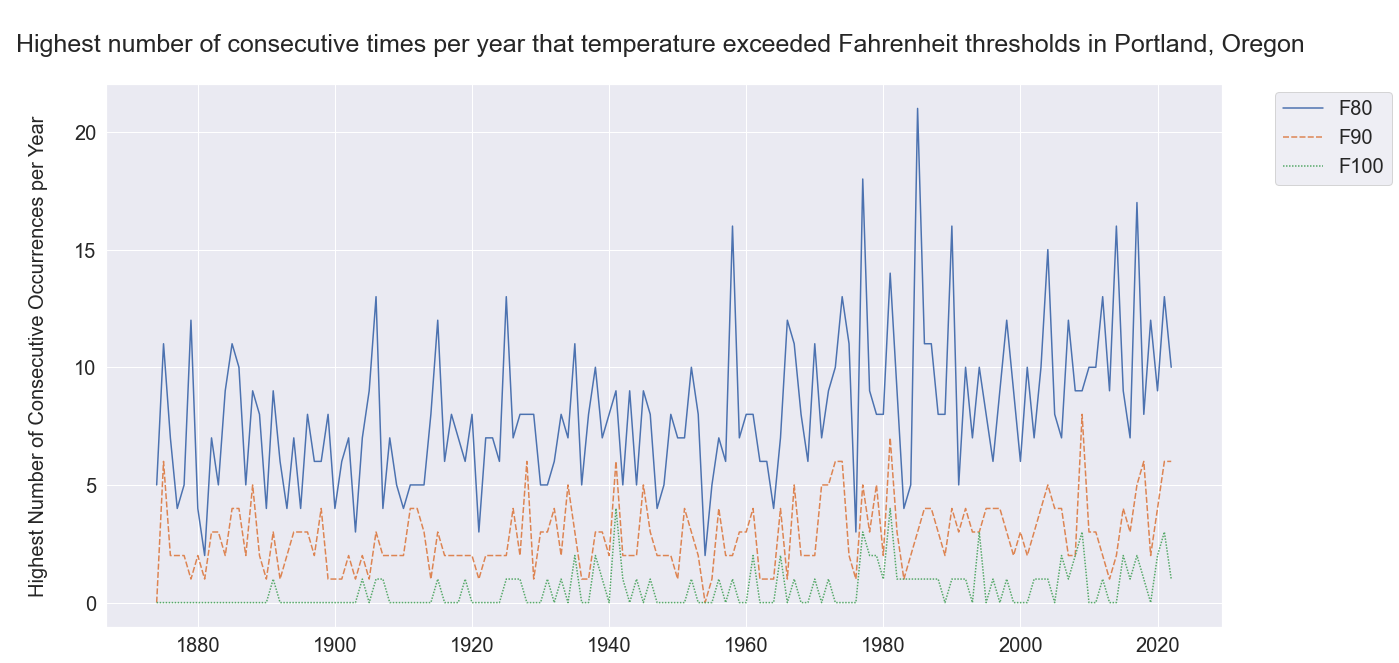

In [14]:
F_df = F80_df.merge(F90_df).merge(F100_df)
consecp = F_df.set_index(['YEAR'])
p2 = sns.set(rc={'figure.figsize':(20,10)})
p2 = sns.lineplot(data=consecp)

# Plotting 
p2.set_title('\nHighest number of consecutive times per year that temperature \
exceeded Fahrenheit thresholds in Portland, Oregon \n', fontsize=25)
p2.set_xlabel("\n", fontsize=20)
p2.set_ylabel("\nHighest Number of Consecutive Occurrences per Year\n", fontsize=20)
p2.tick_params(axis='x', labelsize=20)
p2.tick_params(axis='y', labelsize=20)
p2.legend(loc=10, prop={'size': 20})
legend = p2.get_legend()
legend.set_bbox_to_anchor((1.1, .9))


In [15]:
pd.set_option('display.max_rows', None)
# consecp.sort_values('F90', ascending=False)
consecp.sort_values('F80', ascending=False)

,F80,F90,F100
YEAR,,,
1985,21,3,1
1977,18,5,3
2017,17,5,2
1990,16,4,1
1958,16,2,1
2014,16,2,0
2004,15,5,1
1981,14,7,4
1906,13,3,1
